# Breathing Rate Analysis (15s Windows)

This notebook documents the exploratory data analysis (EDA) and results summary  
for breathing rate estimates computed on 15-second windows.  

The workflow proceeds step-by-step, covering:
- Data loading and integrity checks
- Descriptive statistics
- Distribution analysis (histograms, Gaussian fit, KDE)
- Time series visualization (raw vs. rolling median)
- Missingness analysis
- Outlier detection and visualization
- Final conclusions and summary statistics

All figures and tables produced here are saved to the `output/figs/`  
and `output/tables/` directories, respectively, for inclusion in the  
project README and appendix.


# Setup and Imports

Import all required Python libraries for data loading, analysis, and plotting.  
All imports are consolidated here for reproducibility and consistency.


In [106]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates
from scipy.stats import norm, gaussian_kde

# Paths, Directories, and Plot Styles

Define project paths, output directories, global plotting styles,  
and helper functions for consistent labeling of time axes.


In [107]:
root = Path.cwd().parent if Path.cwd().name.lower() in {"notebook","notebooks"} else Path.cwd()
csv_15s = root / "output" / "breathing_rate_15s_final.csv"
out_figs = root / "output" / "figs"
out_tables = root / "output" / "tables"
out_figs.mkdir(parents=True, exist_ok=True)
out_tables.mkdir(parents=True, exist_ok=True)

plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 12,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "grid.alpha": 0.6,
})

def time_axis_label(df, col="time"):
    """
    Return an x-axis label like:
    Time (elapsed relative to start at HH:MM:SS)
    """
    t0 = df[col].iloc[0].strftime("%H:%M:%S")
    return f"Time (elapsed relative to start at {t0})"


# Load 15s Breathing Rate Data

Read the 15-second window breathing rate estimates from CSV,  
coerce values into numeric and datetime formats, and run basic integrity checks.


In [ ]:
df15 = pd.read_csv(csv_15s)
df15["bpm"]  = pd.to_numeric(df15["bpm"], errors="coerce")

df15["time"] = pd.to_datetime(df15["time"], format="%H:%M:%S", errors="coerce")

print("Rows:", len(df15))
print("Missing bpm:", df15["bpm"].isna().sum())
print("Time monotonic:", df15["time"].is_monotonic_increasing)
df15.head(3)


Rows: 207
Missing bpm: 1
Time monotonic: True


,time,bpm
0,1900-01-01 20:41:00,6.5
1,1900-01-01 20:41:15,6.1
2,1900-01-01 20:41:30,22.9


# Descriptive Statistics

Summarize the central tendency, spread, and coverage of the 15s breathing rate data.  
Statistics include min, max, mean, median, percentiles, and percent valid.


In [109]:
stats_tbl = pd.DataFrame({
    "min":[df15["bpm"].min()],
    "p05":[df15["bpm"].quantile(0.05)],
    "p25":[df15["bpm"].quantile(0.25)],
    "median":[df15["bpm"].median()],
    "mean":[df15["bpm"].mean()],
    "p75":[df15["bpm"].quantile(0.75)],
    "p95":[df15["bpm"].quantile(0.95)],
    "max":[df15["bpm"].max()],
    "valid_pct":[100.0*df15["bpm"].notna().mean()],
})
stats_tbl.round(2).to_csv(out_tables/"br15_descriptive.csv", index=False)
stats_tbl.round(2)

,min,p05,p25,median,mean,p75,p95,max,valid_pct
0,2.5,4.5,6.5,7.75,9.12,10.55,16.58,29.3,99.52


# Histogram of Breathing Rates

Visualize the distribution of breathing rates (15s windows) using a histogram.  
Bar colors and edges are styled for clarity, and gridlines added for readability.


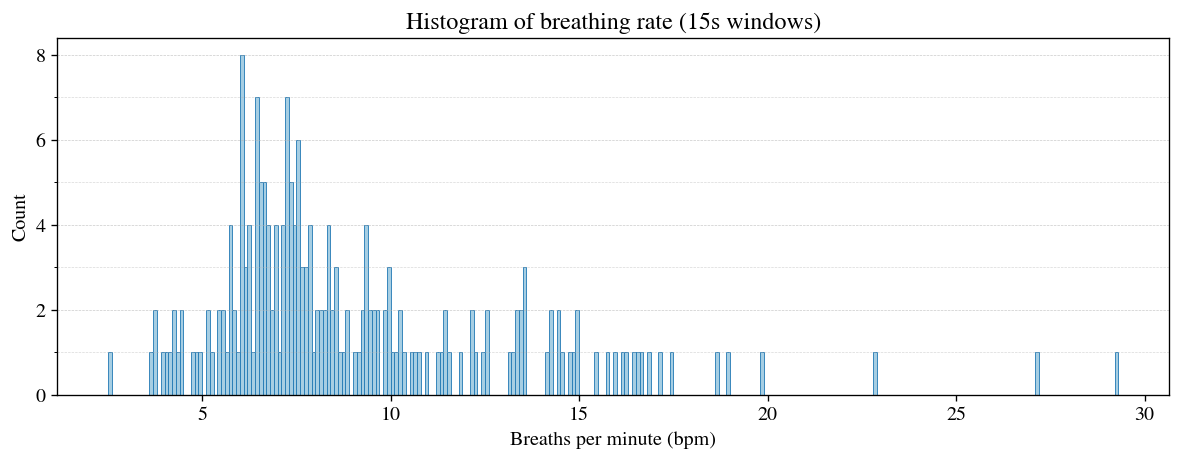

In [110]:
bpm = df15["bpm"].dropna().to_numpy()
lo = np.floor(bpm.min()*10)/10
hi = np.ceil(bpm.max()*10)/10
bins = np.arange(lo, hi+0.1, 0.1)

plt.figure(figsize=(10,4))
plt.hist(bpm, bins=bins, color="#a6cee3", edgecolor="#1f78b4", linewidth=0.5)
plt.xlabel("Breaths per minute (bpm)")
plt.ylabel("Count")
plt.title("Histogram of breathing rate (15s windows)")

ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="major", axis="y", linestyle="--", linewidth=0.4, alpha=0.7)
ax.grid(which="minor", axis="y", linestyle="--", linewidth=0.4, alpha=0.5)

plt.tight_layout()
plt.savefig(out_figs/"br15_hist_horizontal_grid.png", dpi=160)
plt.show()


# Histogram with Gaussian and KDE Overlays

Extend the histogram by overlaying both a Gaussian fit and a non-parametric  
Kernel Density Estimate (KDE), enabling visual comparison between parametric  
and empirical distributions.

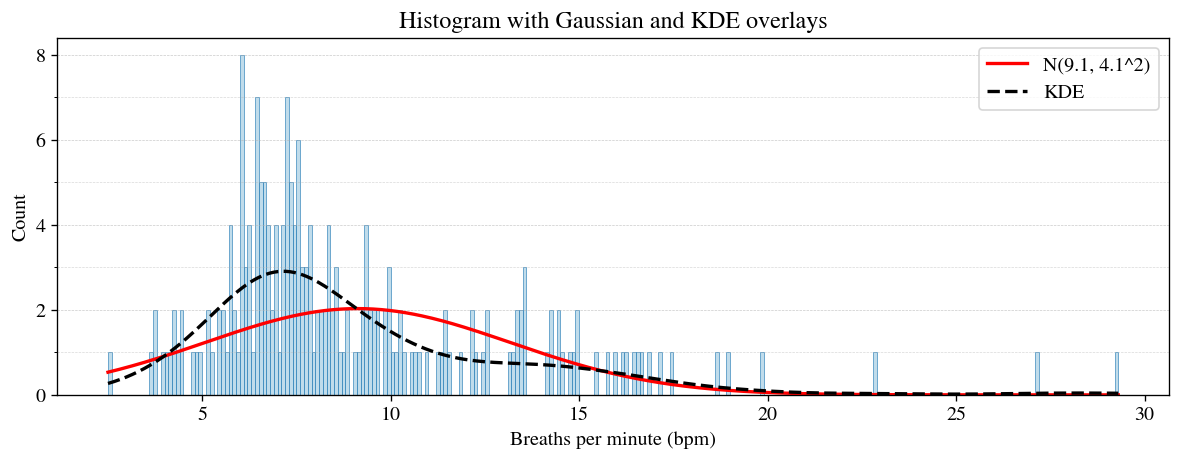

In [ ]:
mu, sigma = bpm.mean(), bpm.std()
x = np.linspace(bpm.min(), bpm.max(), 500)
scale = len(bpm) * (bins[1]-bins[0])

plt.figure(figsize=(10,4))
plt.hist(bpm, bins=bins, color="#a6cee3", edgecolor="#1f78b4", linewidth=0.5, alpha=0.7)
plt.plot(x, norm.pdf(x, mu, sigma)*scale, "r-", lw=2, label=f"N({mu:.1f}, {sigma:.1f}^2)")
kde = gaussian_kde(bpm)
plt.plot(x, kde(x)*scale, "k--", lw=2, label="KDE")
plt.xlabel("Breaths per minute (bpm)")
plt.ylabel("Count")
plt.title("Histogram with Gaussian and KDE overlays")

ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which="major", axis="y", linestyle="--", linewidth=0.4, alpha=0.7)
ax.grid(which="minor", axis="y", linestyle="--", linewidth=0.4, alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig(out_figs/"br15_hist_overlays.png", dpi=160)
plt.show()


# Time Series of Breathing Rate (Full Session)

Plot the raw 15s breathing rate estimates across the entire session.  
Overlay a 75s rolling median to highlight the underlying trend and  
ensure the session origin is clearly labeled on the time axis.


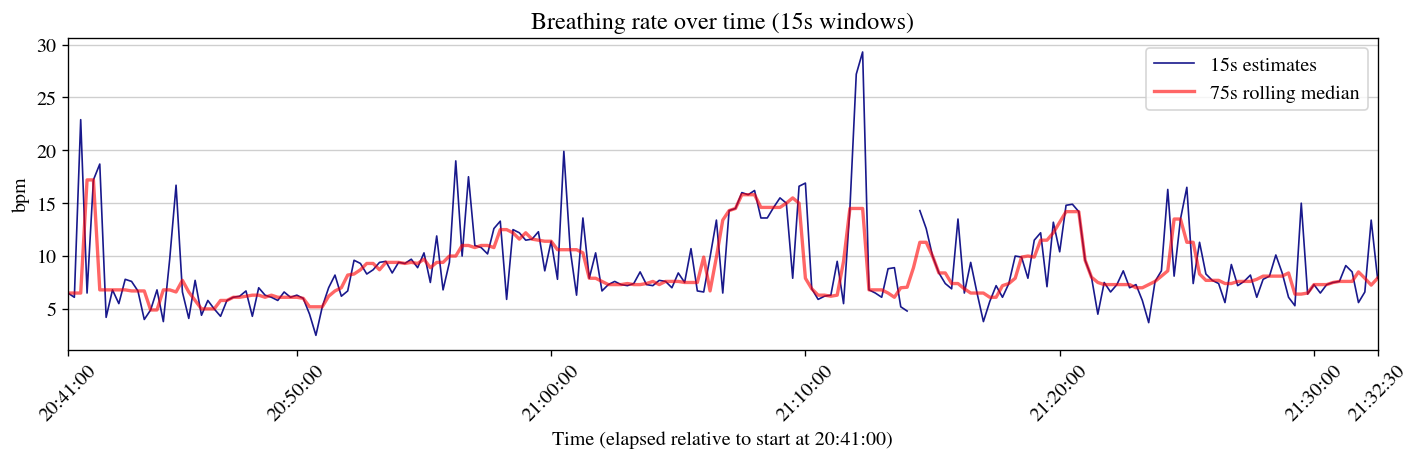

In [119]:
plt.figure(figsize=(12,4))
plt.plot(df15["time"], df15["bpm"], lw=1, color="navy", alpha=0.9, label="15s estimates")

rolling = df15["bpm"].rolling(window=5, center=True, min_periods=1).median()
plt.plot(df15["time"], rolling, lw=2, color="red", alpha=0.6, label="75s rolling median")

plt.xlabel(time_axis_label(df15))
plt.ylabel("bpm")
plt.title("Breathing rate over time (15s windows)")

ax = plt.gca()

# 1) lock to the exact data span
t_first = df15["time"].iloc[0]
t_last  = df15["time"].iloc[-1]
ax.set_xlim(t_first, t_last)
plt.xticks(rotation=45)

# 2) build ticks with origin/last *as ticks* (convert to Matplotlib date numbers)
origin_num = mdates.date2num(t_first)
last_num   = mdates.date2num(t_last)
auto = [t for t in ax.get_xticks() if origin_num < t < last_num]
ticks = [origin_num] + auto + [last_num]
ax.set_xticks(ticks)

# 3) HH:MM:SS labels
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.legend()
plt.tight_layout()
plt.savefig(out_figs/"br15_timeseries_full.png", dpi=160)
plt.show()


# Missingness Analysis

Identify contiguous runs of valid vs missing windows, save them as a table,  
and visualize coverage using a binary heat strip (black = valid, white = missing).  
This reveals data gaps and periods of uninterrupted recording.


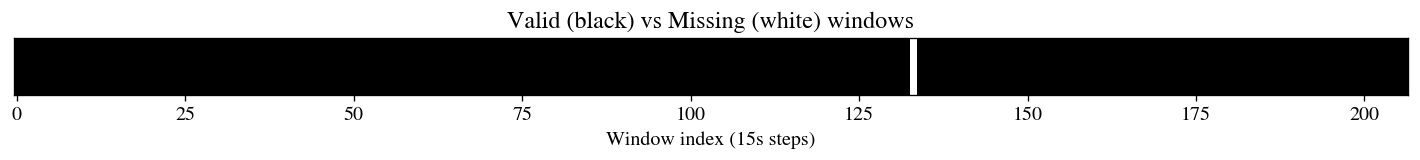

,size,status
bpm,,
1,133,valid
2,1,missing
3,73,valid


In [123]:
plt.figure(figsize=(12,1.5))

# binary validity vector
valid = df15["bpm"].notna().astype(int)

# run-length encoding: sizes of consecutive valid/invalid segments
runs = valid.groupby((valid != valid.shift()).cumsum()).agg(["size","first"])
runs["status"] = runs["first"].map({1: "valid", 0: "missing"})
runs = runs.drop(columns="first")
runs.to_csv(out_tables/"br15_missing_runs.csv")

# heat strip: black = valid, white = missing
plt.imshow(valid.values[np.newaxis, :],
           aspect="auto", cmap="Greys", interpolation="nearest")

plt.yticks([])
plt.xlabel("Window index (15s steps)")
plt.title("Valid (black) vs Missing (white) windows")

plt.tight_layout()
plt.savefig(out_figs/"br15_valid_heat.png", dpi=160)
plt.show()

runs.head()


# Outlier Detection and Visualization

Identify breathing rate outliers using the 3×IQR rule.  
Plot the raw 15s series (navy), the 75s rolling median (red),  
and highlight flagged outliers as red points.  
Save both figure and outlier list for documentation.


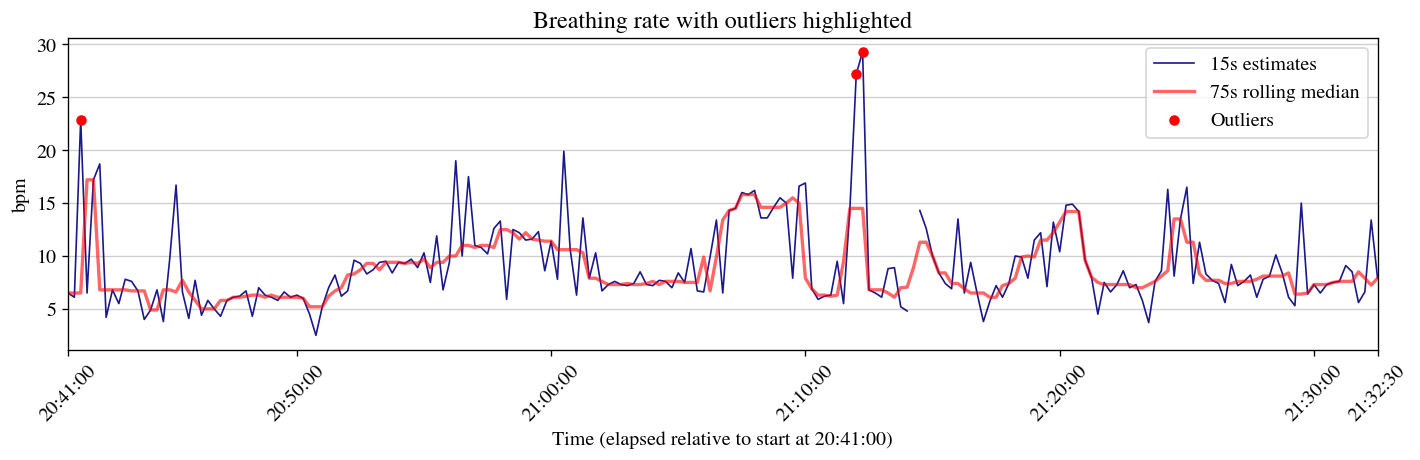

In [124]:
plt.figure(figsize=(12,4))

# outlier detection (3×IQR)
q1, q3 = df15["bpm"].quantile([0.25, 0.75])
iqr = q3 - q1
lo_cut, hi_cut = q1 - 3*iqr, q3 + 3*iqr
outliers = df15[(df15["bpm"] < lo_cut) | (df15["bpm"] > hi_cut)]
outliers.to_csv(out_tables/"br15_outliers.csv", index=False)

# raw series
plt.plot(df15["time"], df15["bpm"],
         lw=1, color="navy", alpha=0.9, label="15s estimates")

# rolling median
rolling = df15["bpm"].rolling(window=5, center=True, min_periods=1).median()
plt.plot(df15["time"], rolling,
         lw=2, color="red", alpha=0.6, label="75s rolling median")

# outlier points
plt.scatter(outliers["time"], outliers["bpm"],
            color="red", s=28, zorder=5, label="Outliers")

plt.xlabel(time_axis_label(df15))
plt.ylabel("bpm")
plt.title("Breathing rate with outliers highlighted")

ax = plt.gca()
t_first, t_last = df15["time"].iloc[0], df15["time"].iloc[-1]
ax.set_xlim(t_first, t_last)

# build ticks with origin + last guaranteed
origin_num = mdates.date2num(t_first)
last_num   = mdates.date2num(t_last)
auto = [t for t in ax.get_xticks() if origin_num < t < last_num]
ticks = [origin_num] + auto + [last_num]
ax.set_xticks(sorted(set(ticks)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(out_figs/"br15_outliers.png", dpi=160)
plt.show()


# Conclusions

Summarize the session with key statistics: start/end time, duration,  
validity, median/IQR, range, and number of outliers.  
Results are printed in a concise bullet-point format, suitable for inclusion  
in the README or final report.


In [125]:
t_first = df15["time"].iloc[0]
t_last  = df15["time"].iloc[-1]
duration_min = (t_last - t_first).total_seconds() / 60.0

conclusions = {
    "Session start": t_first.strftime("%H:%M:%S"),
    "Session end": t_last.strftime("%H:%M:%S"),
    "Duration (min)": f"{duration_min:.2f}",
    "Windows": len(df15),
    "Valid windows": df15["bpm"].notna().sum(),
    "Valid %": f"{100.0 * df15['bpm'].notna().mean():.1f}%",
    "Median bpm": f"{df15['bpm'].median():.1f}",
    "IQR bpm": f"{df15['bpm'].quantile(0.75) - df15['bpm'].quantile(0.25):.1f}",
    "Range bpm": f"{df15['bpm'].min():.1f}–{df15['bpm'].max():.1f}",
    "Outliers (3×IQR)": len(outliers),
}

for k, v in conclusions.items():
    print(f"- {k}: {v}")


- Session start: 20:41:00
- Session end: 21:32:30
- Duration (min): 51.50
- Windows: 207
- Valid windows: 206
- Valid %: 99.5%
- Median bpm: 7.8
- IQR bpm: 4.1
- Range bpm: 2.5–29.3
- Outliers (3×IQR): 3


# Closing Remarks and Next Steps

This appendix notebook provides a structured overview of the 15-second breathing rate  
analysis, from descriptive statistics through visualization and outlier detection.  
Key takeaways include:

- The session was successfully reconstructed with high data validity.
- Median breathing rate and variability were quantified and visualized.
- Outliers were identified using a robust statistical rule (3×IQR).
- Results were exported as figures and tables for integration into the project README.

**Next Steps:**
- If required, extend analysis to additional window sizes (30s, 60s, 120s, 240s).
- Incorporate physiological context or external benchmarks to interpret bpm values.
- Use this framework as a template for future sessions, ensuring consistent outputs.

This notebook, together with the README, forms a transparent and reproducible record  
of the breathing rate estimation workflow.
